# Supplemental Information:

> **"Clonal heterogeneity influences the fate of new adaptive mutations"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 6 (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figures 6, S10, S11 and S12 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [1]:
# Load external dependencies
from setup import *
# Load internal dependencies
import colors,config,plot,utils

%load_ext autoreload
%autoreload 2

%matplotlib inline

/Users/ivg/.virtualenvs/genetic-variation/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In this experiment, we cross individuals of the ancestral population with pre-existing variation and mutant individuals from the evolved population. All of these are diploid cells which undergo sporulation (labelled *spores*) and mating (creating *hybrids*). We evaluate phenotypes of the spore and hybrid genotypes. Phenotypic variation can then be attributed to dominance or epistatic effects.

## Data import

### Spores

In [19]:
# Load data
spores_df = pd.read_csv(dir_data+'pheno/genetic-cross/pheno_spores.csv', encoding='utf-8', keep_default_na=False, na_values='NaN')

# Filter out blank positions and constructs
spores_df = spores_df[~(spores_df['strain'].isin(['control','']))&\
                      ~(spores_df['genotype_long'].isin([u'fpr1Δ',u'tor1Δ']))]

# Set contaminated samples as missing (NaN)
spores_df.loc[(spores_df['contamination']=='yes'),
              ['abs_growth_rate','abs_doubling_time','norm_growth_rate','norm_doubling_time']] = np.nan

# Define individual and replicate
spores_df['individual'] = spores_df[['group','background','gene','tetrad','spore']].apply(tuple, axis=1)
spores_df['replicate'] = spores_df[['group','background','gene','tetrad','spore','plate','row','column']].apply(tuple, axis=1)

# # Filter out measurement replicates with >5% measurement error
# spores_df['pct'] = spores_df.groupby(['selection','environment','replicate'])['growth_rate']\
# .apply(lambda x: (x-x.mean())/float(x.mean()))
# spores_df = spores_df[abs(spores_df['pct'])<0.05]

spores_df.head()  # show dataframe header to stdout

,selection,environment,layout,plate,row,column,strain,group,background,gene,...,spore,mating,auxotrophy,contamination,abs_growth_rate,abs_doubling_time,norm_growth_rate,norm_doubling_time,individual,replicate
0,HU,HU,0,0,0,0,spore,evolved,WAxNA,RNR4,...,2,MATα,lys2-,no,0.077512,3.689437,0.872196,0.197277,"(evolved, WAxNA, RNR4, A, 2)","(evolved, WAxNA, RNR4, A, 2, 0, 0, 0)"
1,HU,HU,0,0,0,1,spore,evolved,WAxNA,RNR4,...,2,MATα,lys2-,no,0.044785,4.480845,0.715659,0.482655,"(evolved, WAxNA, RNR4, A, 2)","(evolved, WAxNA, RNR4, A, 2, 0, 0, 1)"
2,HU,HU,0,0,0,2,spore,evolved,WAxNA,RNR4,...,2,MATα,lys2-,no,0.042782,4.546851,0.698703,0.517250,"(evolved, WAxNA, RNR4, A, 2)","(evolved, WAxNA, RNR4, A, 2, 0, 0, 2)"
3,HU,HU,0,0,0,3,spore,evolved,WAxNA,RNR4,...,2,MATα,lys2-,no,0.040836,4.614019,0.680785,0.554730,"(evolved, WAxNA, RNR4, A, 2)","(evolved, WAxNA, RNR4, A, 2, 0, 0, 3)"
4,HU,HU,0,0,0,4,spore,evolved,WAxNA,RNR4,...,4,MATα,lys2-,no,0.071727,3.801336,0.825483,0.276690,"(evolved, WAxNA, RNR4, B, 4)","(evolved, WAxNA, RNR4, B, 4, 0, 0, 4)"


### Hybrids

In [20]:
# Load data
hybrids_df = pd.read_csv(dir_data+'pheno/genetic-cross/pheno_hybrids.csv', encoding='utf-8', keep_default_na=False, na_values='NaN')

# Combine MATa/α to create tuples
for column in ['strain','group','background','gene','genotype_short','genotype_long','amino_acids']:
    hybrids_df[column] = utils.combine_columns(hybrids_df,u'%s_MATa'%column,u'%s_MATα'%column)
for column in ['auxotrophy','mating','tetrad','spore','strain','contamination']:
    hybrids_df[column] = utils.combine_columns(hybrids_df,u'%s_MATa'%column,u'%s_MATα'%column,mirror=False)

# Filter out blank positions, contamination and constructs
hybrids_df = hybrids_df[~(hybrids_df['strain'].isin([('control','control'),('','')]))&\
                        ~(hybrids_df['genotype_long'].isin([u'fpr1Δ',u'tor1Δ']))]

# Set contaminated samples as missing (NaN)
hybrids_df.loc[hybrids_df['contamination']\
                    .isin([('yes','yes'),('no','yes'),('yes','no')]),
              ['abs_growth_rate','abs_doubling_time','norm_growth_rate','norm_doubling_time']] = np.nan

# Fix diploid genotypes for different genes
hybrids_df.loc[(hybrids_df[u'gene_MATa']=='RNR4')&\
               (hybrids_df[u'gene_MATα']=='RNR2'),'genotype_short'] =\
hybrids_df.loc[(hybrids_df[u'gene_MATa']=='RNR4')&\
               (hybrids_df[u'gene_MATα']=='RNR2'),'genotype_short'].apply(lambda x: x[::-1])
hybrids_df.loc[(hybrids_df[u'gene_MATa']=='TOR1')&\
               (hybrids_df[u'gene_MATα']=='FPR1'),'genotype_short'] =\
hybrids_df.loc[(hybrids_df[u'gene_MATa']=='TOR1')&\
               (hybrids_df[u'gene_MATα']=='FPR1'),'genotype_short'].apply(lambda x: x[::-1])

# Define individual
hybrids_df['individual'] = hybrids_df[['group','background','gene','tetrad','spore']].apply(tuple, axis=1)
hybrids_df['replicate'] = hybrids_df[['group','background','gene','tetrad','spore','plate','row','column']].apply(tuple, axis=1)

# # Filter out measurement replicates with >5% measurement error
# hybrids_df['pct'] = hybrids_df.groupby(['selection','environment','replicate'])['growth_rate']\
# .apply(lambda x: (x-x.mean())/float(x.mean()))
# hybrids_df = hybrids_df[abs(hybrids_df['pct'])<0.05]

hybrids_df.head()  # show dataframe header to stdout

,selection,environment,layout,plate,row,column,strain_MATa,strain_MATα,group_MATa,group_MATα,...,genotype_short,genotype_long,amino_acids,auxotrophy,mating,tetrad,spore,contamination,individual,replicate
1456,HU,HU,1,0,30,16,spore,spore,parents,parents,...,"(+, +)","(, )","(, )","(ura3-, lys2-)","(MATa, MATα)","(, )","(, )","(no, no)","((parents, parents), (NA, NA), (, ), (, ), (, ))","((parents, parents), (NA, NA), (, ), (, ), (, ..."
1457,HU,HU,1,0,30,17,spore,spore,parents,parents,...,"(+, +)","(, )","(, )","(ura3-, lys2-)","(MATa, MATα)","(, )","(, )","(no, no)","((parents, parents), (NA, NA), (, ), (, ), (, ))","((parents, parents), (NA, NA), (, ), (, ), (, ..."
1504,HU,HU,1,0,31,16,spore,spore,parents,parents,...,"(+, +)","(, )","(, )","(ura3-, lys2-)","(MATa, MATα)","(, )","(, )","(no, no)","((parents, parents), (NA, NA), (, ), (, ), (, ))","((parents, parents), (NA, NA), (, ), (, ), (, ..."
10672,HU,SC,1,1,30,16,spore,spore,parents,parents,...,"(+, +)","(, )","(, )","(ura3-, lys2-)","(MATa, MATα)","(, )","(, )","(no, no)","((parents, parents), (NA, NA), (, ), (, ), (, ))","((parents, parents), (NA, NA), (, ), (, ), (, ..."
10673,HU,SC,1,1,30,17,spore,spore,parents,parents,...,"(+, +)","(, )","(, )","(ura3-, lys2-)","(MATa, MATα)","(, )","(, )","(no, no)","((parents, parents), (NA, NA), (, ), (, ), (, ))","((parents, parents), (NA, NA), (, ), (, ), (, ..."


### Clones

In [21]:
# Load data
clone_df = pd.read_csv(dir_data+'pheno/populations/pheno_populations.csv', encoding='utf-8', keep_default_na=False, na_values='NaN')

# Filter out strains used for spatial control
clone_df = clone_df[(clone_df.group == 'ancestral')|\
                    (clone_df.group == 'evolved')]

clone_df['genotype_short'] = map(lambda x: tuple(x.strip("/").split("/")),clone_df['genotype_short'])
clone_df['genotype_long'] = map(lambda x: tuple(x.strip("/").split("/")),clone_df['genotype_long'])

clone_df['group'] = zip(clone_df.group, clone_df.group)
clone_df['background'] = zip(clone_df.background, clone_df.background)
clone_df['gene'] = zip(clone_df.gene, clone_df.gene)

clone_df.head()

,selection,environment,run,index,plate,row,column,group,population,background,...,gene,genotype_short,genotype_long,amino_acids,mating,auxotrophy,abs_growth_rate,abs_doubling_time,norm_growth_rate,norm_doubling_time
0,HU,HU,1,0,0,0,0,"(ancestral, ancestral)",WAxNA_F12_1_HU,"(WAxNA, WAxNA)",...,"(, )","(+, +)","(,)",,MATa/α,,0.064399,3.956813,0.659339,0.600908
1,HU,HU,1,1,0,0,1,"(ancestral, ancestral)",WAxNA_F12_2_HU,"(WAxNA, WAxNA)",...,"(, )","(+, +)","(,)",,MATa/α,,0.040603,4.622281,0.561247,0.833291
2,HU,HU,1,2,0,0,2,"(evolved, evolved)",WAxNA_F12_1_HU_3,"(WAxNA, WAxNA)",...,"(, )","(+, +)","(,)",,MATa/α,,0.065577,3.930664,0.650017,0.621451
3,HU,HU,1,3,0,0,3,"(evolved, evolved)",WAxNA_F12_2_HU_3,"(WAxNA, WAxNA)",...,"(, )","(+, +)","(,)",,MATa/α,,0.058038,4.106870,0.610609,0.711680
4,HU,HU,1,4,0,0,4,"(ancestral, ancestral)",WAxNA_F12_1_HU,"(WAxNA, WAxNA)",...,"(, )","(+, +)","(,)",,MATa/α,,0.060311,4.051425,0.618131,0.694015


### Analysis of variance

In [22]:
lmm_fit = pd.read_csv(dir_data+'pheno/genetic-cross/lmm_fit.csv')
lmm_var_comp = pd.read_csv(dir_data+'pheno/genetic-cross/lmm_var_components.csv')

We need to filter and sort the vector of spore phenotypes and matrix of hybrid phenotypes by environment.

In [23]:
def filter_spores(S, env_evo):
    # Filter by dictionary
    S = S[(S['group'].isin(config.spores_bg['position'][env_evo].keys())) &
          (S['genotype_short'].isin(config.spores_gt_short['position'][env_evo].keys())) &
          (S['background'].isin(config.spores_cl['position'][env_evo].keys()))]
    return S
          
def filter_hybrids(H, env_evo):
    # Filter by dictionary
    H = H[(H['group'].isin(config.hybrids_bg['position'][env_evo].keys())) &
          (H['genotype_short'].isin(config.hybrids_gt_short['position'][env_evo].keys())) &
          (H['background'].isin(config.hybrids_cl['position'][env_evo].keys()))]
    return H
    
def sort_spores(S, env_evo):
    # Apply sorting ranks to reorder rows
    S.loc[:,'rank_group'] = S['group'].map(config.spores_bg['position'][env_evo])
    S.loc[:,'rank_background'] = S['background'].map(config.spores_cl['position'][env_evo])
    S.loc[:,'rank_gene'] = S['gene'].map(config.spores_gn['position'][env_evo])
    S.loc[:,'rank_genotype'] = S['genotype_short'].map(config.spores_gt_short['position'][env_evo])
    S.sort_values(['rank_group','rank_background','rank_gene','rank_genotype'],
                  ascending=True,inplace=True)
    return S

def sort_hybrids(H, env_evo):
    # Apply sorting ranks to reorder rows
    H.loc[:,'rank_group'] = H['group'].map(config.hybrids_bg['position'][env_evo])
    H.loc[:,'rank_background'] = H['background'].map(config.hybrids_cl['position'][env_evo])
    H.loc[:,'rank_gene'] = H['gene'].map(config.hybrids_gn['position'][env_evo])
    H.loc[:,'rank_genotype'] = H['genotype_short'].map(config.hybrids_gt_short['position'][env_evo])
    H.sort_values(['rank_group','rank_background','rank_gene','rank_genotype'],
                  ascending=True,inplace=True)
    return H

## Figure 6 - Background-averaged fitness effects

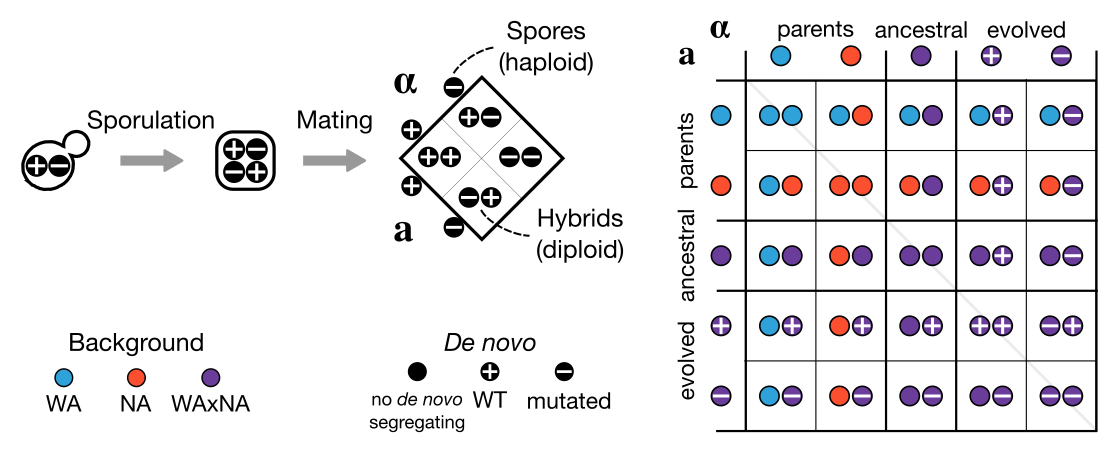

In [24]:
from IPython.display import Image
Image(filename=dir_paper+'figures/figure6/figure6A_schematic_publication.png', retina=True)

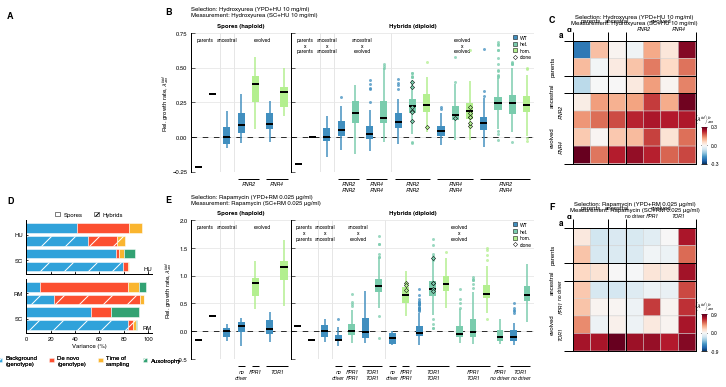

In [45]:
param='norm_growth_rate'

fig = plt.figure(figsize=(12, 6))

grid = gridspec.GridSpec(2, 3, width_ratios=[1.1,3,1.075], hspace=0.35, wspace=0.2)

gs = {}
gs['schematic'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,0])
gs['variance'] = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios=[5,5,2], subplot_spec=grid[1,0], hspace=0.1)
gs[('HU','heatmap')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,2])
gs[('HU','barplot')] = gridspec.GridSpecFromSubplotSpec(1, 24, subplot_spec=grid[0,1], wspace=0)
gs[('RM','heatmap')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,2])
gs[('RM','barplot')] = gridspec.GridSpecFromSubplotSpec(1, 24, subplot_spec=grid[1,1], wspace=0)

### Schematic ###
ax = plt.subplot(gs['schematic'][:])
ax.text(-0.1, 1.125,  chr(ord('A')), transform=ax.transAxes,
        fontsize=9, fontweight='bold', va='center', ha='right')
ax.axis('off')

### Box plots ###
groups_sp = spores_df.groupby(['selection','environment'])
groups_hy = hybrids_df.groupby(['selection','environment'])
groups_cl = clone_df.groupby(['selection','environment'])

for (ii, (env_evo, env_test)) in enumerate([('HU','HU'),('RM','RM')]):
    
    # Group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    C = groups_cl.get_group((env_evo, env_test))
    
    # Filter by dictionary
    S = filter_spores(S, env_evo)
    H = filter_hybrids(H, env_evo)
    
    # Apply sorting ranks to reorder rows
    S = sort_spores(S, env_evo)
    H = sort_hybrids(H, env_evo)
    
    ### Spores barplot ###
    ax1 = plt.subplot(gs[(env_evo,'barplot')][:7])

    ax1.text(-0.2, 1.15,  chr(3*ii + ord('B')), transform=ax1.transAxes,
             fontsize=9, fontweight='bold', va='center', ha='right')
    
    ax1.text(0, 1.15,  
             'Selection: %s\nMeasurement: %s' %\
             (config.selection['long_label'][env_evo], config.environment['long_label'][env_test]), 
             transform=ax1.transAxes,
             fontsize=6, va='center', ha='left')
    
    S = S.groupby(['group','background','gene','genotype_short','tetrad','spore'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']\
    .unstack(level=['group','background','gene','genotype_short'])
    S_ref = S.ix[:,'ancestral'].median().values[0]
    S = S-S_ref
    
    bp = S.plot(
        ax=ax1, kind='box', by='group', return_type='dict',
        labels=S.columns.get_level_values('group')
    )

    colors = [config.spores_gt_short['color'][env_evo][x] for x in S.columns.get_level_values('genotype_short')]
    plot.boxplot_custom(bp, ax1, colors=colors, hatches=[' ']*10)
        
    ax1.set_title('Spores (haploid)', fontsize=6, y=1, weight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel(r'Rel. growth rate, $\lambda^{btd}_{a\alpha}$', fontsize=6, labelpad=2)

    ### Hybrids barplot ###
    ax2 = plt.subplot(gs[(env_evo,'barplot')][7:], sharey=ax1)
    
    H = H.groupby(['group','background','gene','genotype_short','tetrad','spore'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']\
    .unstack(level=['group','background','gene','genotype_short'])
    ix_use = pd.MultiIndex.from_tuples([[('ancestral', 'ancestral')]], names=['group'])
    H_ref = H.loc[:,H.columns.get_level_values('group').isin(ix_use.get_level_values(0))].median().squeeze()
    H = H-H_ref
    
    C = C.groupby(['group','background','gene','genotype_short','isolate'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']
    C_ref = C[('ancestral', 'ancestral')].median()
    C = C-C_ref
    
    C = C.unstack(level=['group','background','gene','genotype_short'])
    C = C.loc[:,(C.columns.get_level_values('group').isin([('evolved','evolved')])\
                 &~(C.columns.get_level_values('gene').isin([('','')])))]
    C = C.reindex(columns=H.columns)
    C = C.dropna(how='all')

    bp = H.plot(
        ax=ax2, kind='box', by='group', return_type='dict', 
        labels=H.columns.get_level_values('group')
    )

    colors = [config.hybrids_gt_short['color'][env_evo][x] for x in H.columns.get_level_values('genotype_short')]
    plot.boxplot_custom(bp, ax2, colors=colors, hatches=[' ']*30)

    for i,d in enumerate(C):
        y = C[d]
        x = [i+1]*len(y)
        ax2.plot(x, y, 
                 mfc=config.hybrids_gt_short['color'][env_evo][d[-1]], mec='k', 
                 ms=3, marker="D", linestyle="None", zorder=6)
    
    ax2.set_title('Hybrids (diploid)', fontsize=6, y=1, weight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('', fontsize=6)
    
    wt_artist = lines.Line2D((0,.75),(0,0), mec='k', mfc=config.hybrids_gt_short['color'][env_evo][('+','+')], marker='s', markersize=4, linestyle='')
    het_artist = lines.Line2D((0,.75),(0,0), mec='k', mfc=config.hybrids_gt_short['color'][env_evo][('+','-')], marker='s', markersize=4, linestyle='')
    hom_artist = lines.Line2D((0,.75),(0,0), mec='k', mfc=config.hybrids_gt_short['color'][env_evo][('-','-')], marker='s', markersize=4, linestyle='')
    clone_artist = lines.Line2D((0,.75),(0,0), mec='k', mfc='w', marker='D', markersize=3, linestyle='')

    leg = ax2.legend([wt_artist,het_artist,hom_artist,clone_artist], 
                     ['WT','het.','hom.','clone'], ncol=1, 
                     frameon=False, loc='upper right',
                     borderaxespad=0, handlelength=0.75, 
                     prop={'size':5}, labelspacing=.32)
        
    # Grid
    for ax, g in zip([ax1,ax2],[S,H]):
        ### horizontal ###
        ax.yaxis.grid(ls="-", lw=.8, color="0.9", zorder=0)
        ax.axhline(y=0., c='k', ls="--", dashes=(7, 7), lw=.8, zorder=1)
        ax.set_axisbelow(True)
        
        ### vertical ###
        ## Background
        xstart, xend, xlabels = plot.set_custom_labels(g.columns, 0)
        # labels
        for k, v in xlabels.iteritems():
            ax.annotate('\nx\n'.join(k) if isinstance(k, tuple) else k, 
                        xy=(v+1, 0.97), xycoords=("data", "axes fraction"),
                        ha='center', va='top', annotation_clip=False, fontsize=5)
        # grid
        xgrid=[xst+1.5 for xst in list(set(xstart.values()))]
        [ax.axvline(x, lw=1.0, ls='-', color='0.9', zorder=0) for x in xgrid]

        ## gene
        xend, xstart, xlabels = plot.set_custom_labels(g.columns, 2)
        
        transform = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        for k in xlabels:
            if (k!='') & (k!=('','')):
                if abs(xstart[k]-xend[k])>0:
                    line = lines.Line2D([xstart[k]+.75,xend[k]+1.25], [-.05,-.05], 
                                        color='k', lw=1, transform=transform)
                else:
                    line = lines.Line2D([xstart[k]+.75,xend[k]+1.25], [-.05,-.05], 
                                        color='k', lw=1, transform=transform)
                ax.add_line(line)
                line.set_clip_on(False)
        
        ax.set_xticks([x+1 for x in xlabels.values()], minor=False)
        di = {u'no driver': u'no\ndriver', u'/': u'',
              u'\nRNR2': u'RNR2\nRNR2', u'\nRNR4': u'RNR4\nRNR4',
              u'\nno driver': u'no\ndriver', u'no driver\nno driver': u'no\ndriver',
              u'\nFPR1': u'FPR1\nFPR1', u'\nTOR1': u'TOR1\nTOR1'}
        xlabels = ['\n'.join(k) if isinstance(k, tuple) else k for k in xlabels.keys()]
        xlabels = [di[x] if x in di else x for x in xlabels]
        ax.set_xticklabels(xlabels, minor=False, fontsize=5, style='italic', va='top')
                
        ax.tick_params(axis='x', which='minor', size=0, pad=-30)
        ax.tick_params(axis='x', which='major', size=0, pad=10)
        ax.tick_params(axis='y', which='major', labelsize=6)
        
        if env_evo=='HU':
            ax.set_ylim(-0.25,0.75)
            ax.yaxis.set_major_locator( ticker.MaxNLocator(nbins = 4) )
            ax.yaxis.set_minor_locator( ticker.MaxNLocator(nbins = 4) )
        elif env_evo=='RM':
            ax.set_ylim(-0.5,2.0)
            ax.yaxis.set_major_locator( ticker.MaxNLocator(nbins = 5) )
            ax.yaxis.set_minor_locator( ticker.MaxNLocator(nbins = 5) )

### Heatmaps ###
for (ii, (env_evo, env_test)) in enumerate([('HU','HU'),('RM','RM')]):
    
    # Group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    
    # Apply sorting ranks to reorder rows
    S = sort_spores(S, env_evo)
    H = sort_hybrids(H, env_evo)

    ax = plt.subplot(gs[(env_evo,'heatmap')][:])
        
    ax.text(-0.15, 1.175,  chr(3*ii + ord('C')), transform=ax.transAxes,
             fontsize=9, fontweight='bold', va='center', ha='right')
    
    ax.text(0.5, 1.175,  
            'Selection: %s\nMeasurement: %s' %\
            (config.selection['long_label'][env_evo], config.environment['long_label'][env_test]), 
            transform=ax.transAxes,
            fontsize=6, va='center', ha='center')
    
    # Spores
    S = S.groupby([u'mating',u'group',u'background',u'genotype_short',u'gene'],
                    sort=False).agg(np.mean)[param]
    S_ref = S.ix[:,'ancestral'].mean()
    S = S-S_ref
    
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(S.min(), S.max())
    vmin = -vmax

    plot.heatmap_spores(
        S, ax, title, 
        xlabel, ylabel, xticklabels, yticklabels, 
        cmap=plt.cm.RdBu_r, vmin=vmin, vmax=vmax, radius=0.25
    )
    
    # Hybrids    
    H = H.groupby([u'group_MATa',u'background_MATa',u'gene_MATa',u'genotype_short_MATa',
                   u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα'],
                    sort=False).agg(np.mean)[param]
    H = H.unstack(level=[u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα'])
    H_ref = H.loc['ancestral','ancestral'].loc['WAxNA','WAxNA'].values.squeeze()
    H = H-H_ref

    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(np.nanmin(H), np.nanmax(H), key=abs)#H.values.max()
    vmin = -vmax
    legend_title = r'$\langle\lambda^{td}\rangle_{a\alpha}^b$'
    
    plot.heatmap_hybrids(
        H, ax, title, 
        xlabel, ylabel, xticklabels, yticklabels, 
        fold=False, legend_title=legend_title, cmap=plt.cm.RdBu_r, 
        vmin=vmin, vmax=vmax, pad=30
    )
    
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    
    ax.annotate(r'$\mathbf{a}$', xy=(-0.1, 1.01), xycoords=('axes fraction', 'axes fraction'),
                 ha='center', va='bottom', annotation_clip=False, weight='bold', fontsize=8)
    ax.annotate(r'$\mathbf{\alpha}$', xy=(-0.01, 1.1), xycoords=('axes fraction', 'axes fraction'),
                 ha='right', va='center', annotation_clip=False, weight='bold', fontsize=8)
    
    ## Gene
    # labels
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 2)
    for k, v in xlabels.iteritems():
        ax.annotate(k, xy=(v+0.5, 1.12), xycoords=("data", "axes fraction"),
                    ha='center', va='top', annotation_clip=False, 
                    style=('italic' if k!='no driver' else 'normal'), fontsize=5)
    ystart, yend, ylabels = plot.set_custom_labels(H.index, 2)
    for k, v in xlabels.iteritems():
        ax.annotate(k, xy=(-0.12, v+0.5), xycoords=("axes fraction", "data"),
                    ha='left', va='center', annotation_clip=False, 
                    style=('italic' if k!='no driver' else 'normal'), fontsize=5, rotation=90)
    
    ## Background
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 0)
    ax.set_xticks([x+0.5 for x in xlabels.values()], minor=False)
    ax.set_xticklabels(xlabels.keys(), minor=False, fontsize=6)
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax.axvline(g, lw=1, ls="-", color="black") for g in xgrid]
    
    ystart, yend, ylabels= plot.set_custom_labels(H.columns, 0)
    ax.set_yticks([y+0.5 for y in ylabels.values()], minor=False)
    ax.set_yticklabels(ylabels.keys(), minor=False, fontsize=6, rotation=90)
    ygrid=[yst+1. for yst in list(set(ystart.values()))]
    [ax.axhline(g, lw=1, ls="-", color="black") for g in ygrid]

    for x in ([-1]+xstart.values()):
        line = lines.Line2D([x+1,x+1], [0.,-.5], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    for y in ([-1]+ystart.values()):
        line = lines.Line2D([0.,-.5], [y+1,y+1], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ax.tick_params(axis='both', which='minor', size=0, pad=10)
    ax.tick_params(axis='both', which='major', size=0, pad=18)

### Variance components ###
var_comp = lmm_var_comp.set_index(['selection','environment','type'])
var_comp = var_comp.sort_index(level=['selection','environment','type'])
var_comp = var_comp.sort_index(ascending=[False,False,True])

# Fix columns
var_comp = var_comp.rename(
    columns={
        'background (genotype)':'Background\n(genotype)',
        'de novo (genotype)':'De novo\n(genotype)',
        'time':'Time of\nsampling',
        'auxotrophy':'Auxotrophy'
    }
)

axes = {}

for ii, (env_evo, ge) in enumerate(var_comp.groupby(level='selection')):
        
    if env_evo=='HU':
        axes[env_evo] = plt.subplot(gs['variance'][ii])
        axes[env_evo].text(-0.1, 1.35,  chr(ord('D')), transform=axes[env_evo].transAxes,
                           fontsize=9, fontweight='bold', va='center', ha='right')
    else:
        axes[env_evo] = plt.subplot(gs['variance'][ii], sharex=axes['HU'])
        
    ax = axes[env_evo]
    utils.simple_axes(ax)
    
    ge.plot(
        ax=ax, kind='barh', stacked=True, 
        color=[config.factors['color'][x] for x in ge.columns], edgecolor='w',
        align='center', legend=False, width=0.75, rasterized=True
    )
    
    bars = ax.patches
    hatches = [config.factors['hatch'][x] for x in ge.index.get_level_values('type')]*len(ge)

    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    
    # x-axis
    ax.set_xlabel('Variance (%)', fontsize=6, labelpad=2, visible=True)
    xscale = 1e-2
    xticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/xscale))
    ax.xaxis.set_major_formatter(xticks)
    # y-axis
    ax.set_ylabel('')
    ystart, yend, ylabels = plot.set_custom_labels(ge.index, 1)
    ax.set_yticks(ylabels.values())
    ax.set_yticklabels(ylabels.keys(), fontsize=6)
    
    # Annotate panels and axis
    ax.annotate(env_evo, xy=(1, 0.05), xycoords=('axes fraction', 'axes fraction'),
                ha='right', va='bottom', fontsize=6)
    
    ax.tick_params(axis='both', which='major', labelsize=6, size=2)
    
# Fix x-axis labels (missing due to boxplot styling)
axes['RM'].xaxis.set_visible(True)
plt.setp(axes['RM'].get_xticklabels(), visible=True)

leg1 = ax.legend(bbox_to_anchor=(0.5, -0.65), ncol=4,
                 frameon=False, loc='lower center',
                 borderaxespad=0, handlelength=0.75, prop={'size':6})
    
s_artist = patches.Rectangle((0,0), width=1, height=1, 
                             facecolor='w', edgecolor='k')
h_artist = patches.Rectangle((0,0), width=1, height=1, hatch='///', 
                             facecolor='w', edgecolor='k')

leg2 = axes['HU'].legend([s_artist,h_artist], ['Spores','Hybrids'],
                         bbox_to_anchor=(0.5, 1.2), ncol=2, 
                         frameon=False, loc='upper center',
                         borderaxespad=0, handlelength=0.75, prop={'size':6})

ax.add_artist(leg1)

plot.save_figure(dir_paper+'figures/figure6/figure6')
plt.show()

In [46]:
H.loc['ancestral','ancestral'].loc['WAxNA','WAxNA']#.values.squeeze()

,genotype_short_MATα,+
gene_MATa,genotype_short_MATa,
,+,0.0


**Fig. 6:** Fitness contribution of genetic background and *de novo* mutations. (**A**) To determine fitness effects of background variation and de novo mutations in hydroxyurea (*RNR2*, *RNR4*) and rapamycin (*FPR1*, *TOR1*), we isolated individuals from ancestral and evolved populations. From these diploid cells, we sporulated and selected haploid segregants of each mating type. Spores with mutations in *RNR2*, *RNR4* and *TOR1* were genotyped to test if they carry the wild-type or mutated allele. We crossed the *MAT*a and *MAT*α versions to create hybrids (48x48 in hydroxyurea and 56x56 in rapamycin). Independent segregants were used to measure biological variability of ancestral and evolved backgrounds. All panels follow this legend. (**B**, **E**) Relative growth rate, $\lambda$, measured with respect to the ancestral population for multiple combinations (background genotype, $b$; *de novo* genotype, $d$; time of sampling during the selection phase, $t$; auxotrophy, $x$) and averaged over measurement replicates. Medians and 25%/75% percentiles across groups are shown, with medians as horizontal black lines and colored by de novo genotype [wild-type +/+ (blue); heterozygote +/− (cyan); homozygote −/− (green)]. Outliers (circles) and isolated, selected clones with matching genotypes (diamonds) are highlighted. (**D**) Variance decomposition of the growth rate of spores (solid) and hybrids (hatched) that can be attributed to different components using a linear mixed model. Estimates of variance components are obtained by restricted maximum likelihood (Fig. S12 and Table S6). (**C**, **F**) Ensemble average of the growth rate of spores  and hybrids . An extended version of the figure with all combinations and controls can be found in Figs. S11 and S12, respectively.

## Figure S10 - Background-averaged fitness effects (full matrix)

Spores
Selection: HU, Environment: HU, Pass:   96, Fail:    0
Hybrids
Selection: HU, Environment: HU, Pass: 2248, Fail:   56

Spores
Selection: HU, Environment: SC, Pass:   96, Fail:    0
Hybrids
Selection: HU, Environment: SC, Pass: 2248, Fail:   56

Spores
Selection: RM, Environment: RM, Pass:  108, Fail:    4
Hybrids
Selection: RM, Environment: RM, Pass: 2482, Fail:  654

Spores
Selection: RM, Environment: SC, Pass:  108, Fail:    4
Hybrids
Selection: RM, Environment: SC, Pass: 2477, Fail:  659



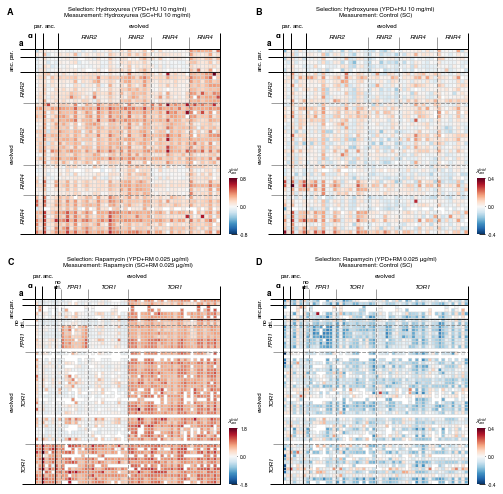

In [39]:
param='norm_growth_rate'

fig = plt.figure(figsize=(8, 8))

grid = gridspec.GridSpec(2, 2, hspace=0.35, wspace=0.25)

gs = {}
gs[('HU','HU')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,0])
gs[('HU','SC')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,1])
gs[('RM','RM')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,0])
gs[('RM','SC')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,1])

groups_sp = spores_df.groupby(['selection','environment'])
groups_hy = hybrids_df.groupby(['selection','environment'])
groups_cl = clone_df.groupby(['selection','environment'])

for (ii, (env_evo, env_test)) in enumerate([('HU','HU'),('HU','SC'),('RM','RM'),('RM','SC')]):
    
    # Group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    C = groups_cl.get_group((env_evo, env_test))
    
    # Apply sorting ranks to reorder rows
    S = sort_spores(S, env_evo)
    H = sort_hybrids(H, env_evo)

    ### Heatmap ###
    ax = plt.subplot(gs[(env_evo, env_test)][0])
    
    ax.text(-0.115, 1.2,  chr(ii + ord('A')), transform=ax.transAxes,
            fontsize=9, fontweight='bold', va='center', ha='right')
    
    ax.text(0.5, 1.2,  
            'Selection: %s\nMeasurement: %s' %\
            (config.selection['long_label'][env_evo], config.environment['long_label'][env_test]), 
            transform=ax.transAxes,
            fontsize=6, va='center', ha='center')
    
    # Spores
    S = S.groupby([u'mating',u'group',u'background',u'gene',u'genotype_short',u'tetrad',u'spore'],
                    sort=False)[param].agg(np.median).reset_index()
    S = S.set_index('mating')[param]
    S_ref = np.nanmean(S)
    S = S-S_ref
        
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(S.min(), S.max())
    vmin = -vmax
    
    plot.heatmap_spores(
        S, ax, title, 
        xlabel, ylabel, xticklabels, yticklabels, 
        cmap=plt.cm.RdBu_r, vmin=vmin, vmax=vmax, radius=0.5
    )
    
    # Hybrids    
    H = H.groupby([u'group_MATa',u'background_MATa',u'gene_MATa',u'genotype_short_MATa',u'tetrad_MATa',u'spore_MATa',
                   u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα',u'tetrad_MATα',u'spore_MATα'],
                    sort=False).agg(np.median)[param]
    H = H.unstack(level=[u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα',u'tetrad_MATα',u'spore_MATα'])
    H_ref = np.nanmean(H.loc['ancestral','ancestral'].loc['WAxNA','WAxNA'])
    H = H-H_ref

    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(np.nanmin(H), np.nanmax(H), key=abs)
    vmin = -vmax
    legend_title = r'$\lambda^{btd}_{a\alpha}$'
    
    plot.heatmap_hybrids(
        H, ax, title,
        xlabel, ylabel, xticklabels, yticklabels, 
        fold=False, legend_title=legend_title, cmap=plt.cm.RdBu_r, 
        vmin=vmin, vmax=vmax, pad=30
    )
    
    print 'Spores\nSelection: %s, Environment: %s, Pass: %4d, Fail: %4d' \
    % (env_evo, env_test, S.notnull().values.flatten().sum(), S.isnull().values.flatten().sum())
    print 'Hybrids\nSelection: %s, Environment: %s, Pass: %4d, Fail: %4d\n' \
    % (env_evo, env_test, H.notnull().values.flatten().sum(), H.isnull().values.flatten().sum())
    
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    
    ax.annotate(r'$\mathbf{a}$', xy=(-0.075, 1.01), xycoords=('axes fraction', 'axes fraction'),
                 ha='center', va='bottom', annotation_clip=False, weight='bold', fontsize=8)
    ax.annotate(r'$\mathbf{\alpha}$', xy=(-0.01, 1.075), xycoords=('axes fraction', 'axes fraction'),
                 ha='right', va='center', annotation_clip=False, weight='bold', fontsize=8)
    
    ## Gene + genotype
    # labels and grid
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, slice(2, 4))
    for k, v in xlabels.iteritems():
        ax.annotate(k[0].replace('no driver','no\ndri.'), 
                    xy=(v+0.5, 1.05), xycoords=("data", "axes fraction"),
                    ha='center', va='bottom', annotation_clip=False, 
                    style=('italic' if k[0]!='no driver' else 'normal'), fontsize=6)
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax.axvline(g, lw=.75, ls="--", dashes=(5, 2), color="gray") for g in xgrid]
    for x in ([-1]+xstart.values()):
        line = lines.Line2D([x+1,x+1], [0.,-3], color='gray', ls='-', lw=.75)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ystart, yend, ylabels = plot.set_custom_labels(H.index, slice(2, 4))
    for k, v in ylabels.iteritems():
        ax.annotate(k[0].replace('no driver','no\ndri.'), 
                    xy=(-0.05, v+0.5), xycoords=("axes fraction", "data"),
                    ha='right', va='center', annotation_clip=False,  
                    style=('italic' if k[0]!='no driver' else 'normal'), fontsize=6, rotation=90)
    ygrid=[yst+1. for yst in list(set(ystart.values()))]
    [ax.axhline(g, lw=.75, ls="--", dashes=(5, 2), color="gray") for g in ygrid]
    for y in ([-1]+ystart.values()):
        line = lines.Line2D([0.,-3], [y+1,y+1], color='gray', ls='-', lw=.75)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ## Background
    # labels and grid
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 0)
    for k, v in xlabels.iteritems():
        ax.annotate(config.population['short_label'][k], 
                    xy=(v+0.5, config.population['pad'][k]+1), xycoords=("data", "axes fraction"),
                    ha='center', va='bottom', annotation_clip=False, fontsize=6)
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax.axvline(g, lw=.75, ls="-", color="k") for g in xgrid]
    for x in ([-1]+xstart.values()):
        line = lines.Line2D([x+1,x+1], [0.,-4], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ystart, yend, ylabels = plot.set_custom_labels(H.index, 0)
    for k, v in ylabels.iteritems():
        ax.annotate(config.population['short_label'][k], 
                    xy=(-config.population['pad'][k], v+0.5), xycoords=("axes fraction", "data"),
                    ha='right', va='center', annotation_clip=False, fontsize=6, rotation=90)
    ygrid=[yst+1. for yst in list(set(ystart.values()))]
    [ax.axhline(g, lw=.75, ls="-", color="k") for g in ygrid]
    for y in ([-1]+ystart.values()):
        line = lines.Line2D([0.,-4], [y+1,y+1], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ax.tick_params(axis='both', which='minor', size=0, pad=2)
    ax.tick_params(axis='both', which='major', size=0, pad=15)

plot.save_figure(dir_supp+'figures/supp_figure_pheno_cross/supp_figure_pheno_cross_extended')
plt.show()

**Fig. S10**: Fitness contribution of genetic background and *de novo* mutations. Given an ensemble of $n_b$ unique genetic backgrounds (${n_b\,{=}\,48}$ in hydroxyurea and ${n_b\,{=}\,56}$ in rapamycin), we constructed a matrix of size $n_b \times n_b$ where every unique haploid background is crossed against itself and all other haploid backgrounds, and the two must be of opposite mating type (*MAT*a or *MAT*α). Each matrix element is labeled by background genotype, $b$; *de novo* genotype, $d$; time, $t$; and auxotrophy, $x$. Measurements of relative growth rates of spores $\lambda^{btd}_{\{a,\alpha\}}$ and hybrids $\lambda^{btd}_{a\alpha}$ are shown, normalized with respect to the ancestral WAxNA crosses. Measurements are taken in (**A**) SC+HU 10 $\text{mg ml}^{-1}$ and (**B**) SC; (**C**) SC+RM 0.025 $\mu\text{g ml}^{-1}$ and (**D**) SC, respectively. The color scale for all matrices to the right of each panel indicates the relative fold-change with respect to the ancestral WAxNA crosses. White boxes indicate missing data due to mating inefficiency and slow growth.

## Figure S11- Background-averaged fitness effects (control)

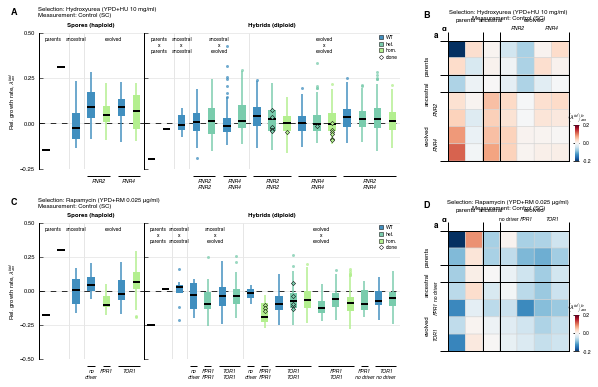

In [43]:
param='norm_growth_rate'

fig = plt.figure(figsize=(9.5, 6))

grid = gridspec.GridSpec(2, 2, width_ratios=[3,1], hspace=0.4, wspace=0.2)

gs = {}
gs[('HU','barplot')] = gridspec.GridSpecFromSubplotSpec(1, 24, subplot_spec=grid[0,0], wspace=0)
gs[('HU','heatmap')] = gridspec.GridSpecFromSubplotSpec(1, 1,subplot_spec=grid[0,1])
gs[('RM','barplot')] = gridspec.GridSpecFromSubplotSpec(1, 24, subplot_spec=grid[1,0], wspace=0)
gs[('RM','heatmap')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,1])

### Box plots ###
groups_sp = spores_df.groupby(['selection','environment'])
groups_hy = hybrids_df.groupby(['selection','environment'])
groups_cl = clone_df.groupby(['selection','environment'])

for (ii, (env_evo, env_test)) in enumerate([('HU','SC'),('RM','SC')]):
    
    # Group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    C = groups_cl.get_group((env_evo, env_test))
    
    # Filter by dictionary
    S = filter_spores(S, env_evo)
    H = filter_hybrids(H, env_evo)
    
    # Apply sorting ranks to reorder rows
    S = sort_spores(S, env_evo)
    H = sort_hybrids(H, env_evo)
    
    ### Spores barplot ###
    ax1 = plt.subplot(gs[(env_evo,'barplot')][:7])

    ax1.text(-0.2, 1.15,  chr(2*ii + ord('A')), transform=ax1.transAxes,
             fontsize=9, fontweight='bold', va='center', ha='right')
    
    ax1.text(0, 1.15,  
             'Selection: %s\nMeasurement: %s' %\
             (config.selection['long_label'][env_evo], config.environment['long_label'][env_test]), 
             transform=ax1.transAxes,
             fontsize=6, va='center', ha='left')
    
    S = S.groupby(['group','background','gene','genotype_short','tetrad','spore'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']\
    .unstack(level=['group','background','gene','genotype_short'])
    S_ref = S.ix[:,'ancestral'].mean().values[0]
    S = S-S_ref
    
    bp = S.plot(
        ax=ax1, kind='box', by='group', return_type='dict',
        labels=S.columns.get_level_values('group')
    )

    plot.boxplot_custom(bp, ax1,
                        colors=[config.spores_gt_short['color'][env_evo][x] for x in S.columns.get_level_values('genotype_short')],
                        hatches=[' ']*10)
    
    ax1.set_title('Spores (haploid)', fontsize=6, weight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel(r'Rel. growth rate, $\lambda^{btd}_{a\alpha}$', fontsize=6, labelpad=2)

    ### Hybrids barplot ###
    ax2 = plt.subplot(gs[(env_evo,'barplot')][7:], sharey=ax1)
    
    H = H.groupby(['group','background','gene','genotype_short','tetrad','spore'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']\
    .unstack(level=['group','background','gene','genotype_short'])
    ix_use = pd.MultiIndex.from_tuples([[('ancestral', 'ancestral')]], names=['group'])
    H_ref = H.loc[:,H.columns.get_level_values('group').isin(ix_use.get_level_values(0))].mean().squeeze()
    H = H-H_ref
    
    C = C.groupby(['group','background','gene','genotype_short','isolate'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']
    C_ref = C[('ancestral', 'ancestral')].mean()

    C = C-C_ref
    C = C.unstack(level=['group','background','gene','genotype_short'])
    C = C.loc[:,(C.columns.get_level_values('group').isin([('evolved','evolved')])\
                 &~(C.columns.get_level_values('gene').isin([('','')])))]
    C = C.reindex(columns=H.columns)
    C = C.dropna(how='all')

    bp = H.plot(
        ax=ax2, kind='box', by='group', return_type='dict', 
        labels=H.columns.get_level_values('group')
    )

    plot.boxplot_custom(bp, ax2, 
                        colors=[config.hybrids_gt_short['color'][env_evo][x] for x in H.columns.get_level_values('genotype_short')],
                        hatches=[' ']*30)

    for i,d in enumerate(C):
        y = C[d]
        x = [i+1]*len(y)
        ax2.plot(x, y, 
                 mfc=config.hybrids_gt_short['color'][env_evo][d[-1]], mec='k', 
                 ms=3, marker='D', linestyle="None", zorder=6)
    
    ax2.set_title('Hybrids (diploid)', fontsize=6, weight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('', fontsize=6)
    
    wt_artist = patches.Rectangle((0,0), width=1, height=1, color=config.hybrids_gt_short['color'][env_evo][('+','+')])
    het_artist = patches.Rectangle((0,0), width=1, height=1, color=config.hybrids_gt_short['color'][env_evo][('+','-')])
    hom_artist = patches.Rectangle((0,0), width=1, height=1, color=config.hybrids_gt_short['color'][env_evo][('-','-')])
    
    wt_artist = lines.Line2D((0,.75),(0,0), mec='k', mfc=config.hybrids_gt_short['color'][env_evo][('+','+')], marker='s', markersize=4, linestyle='')
    het_artist = lines.Line2D((0,.75),(0,0), mec='k', mfc=config.hybrids_gt_short['color'][env_evo][('+','-')], marker='s', markersize=4, linestyle='')
    hom_artist = lines.Line2D((0,.75),(0,0), mec='k', mfc=config.hybrids_gt_short['color'][env_evo][('-','-')], marker='s', markersize=4, linestyle='')
    clone_artist = lines.Line2D((0,1),(0,0), mec='k', mfc='w', marker='D', markersize=3, linestyle='')

    leg = ax2.legend([wt_artist,het_artist,hom_artist,clone_artist], 
                     ['WT','het.','hom.','clone'], ncol=1, 
                     frameon=False, loc='upper right',
                     borderaxespad=0, handlelength=0.75, 
                     prop={'size':5}, labelspacing=.32)
    
    for ax, g in zip([ax1,ax2],[S,H]):
        ### Horizontal ###
        ax.yaxis.grid(ls="-", lw=.8, color="0.9", zorder=-1)
        ax.axhline(y=0., c='k', ls="--", dashes=(7, 7), lw=.8, zorder=1)
        ax.set_axisbelow(True)
        
        ### Bertical ###
        ## Background
        xstart, xend, xlabels = plot.set_custom_labels(g.columns, 0)
        # labels
        for k, v in xlabels.iteritems():
            ax.annotate('\nx\n'.join(k) if isinstance(k, tuple) else k, 
                        xy=(v+1, 0.97), xycoords=("data", "axes fraction"),
                        ha='center', va='top', annotation_clip=False, fontsize=5)
        # grid
        xgrid=[xst+1.5 for xst in list(set(xstart.values()))]
        [ax.axvline(x, lw=1.0, ls='-', color="0.9", zorder=0) for x in xgrid]

        ## Gene
        xend, xstart, xlabels = plot.set_custom_labels(g.columns, 2)
        
        transform = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        for k in xlabels:
            if (k!='') & (k!=('','')):
                if abs(xstart[k]-xend[k])>0:
                    line = lines.Line2D([xstart[k]+.75,xend[k]+1.25], [-.05,-.05], 
                                        color='k', lw=1, transform=transform)
                else:
                    line = lines.Line2D([xstart[k]+.75,xend[k]+1.25], [-.05,-.05], 
                                        color='k', lw=1, transform=transform)
                ax.add_line(line)
                line.set_clip_on(False)
        
        ax.set_xticks([x+1 for x in xlabels.values()], minor=False)
        di = {u'no driver': u'no\ndriver', u'/': u'',
              u'\nRNR2': u'RNR2\nRNR2', u'\nRNR4': u'RNR4\nRNR4',
              u'\nno driver': u'no\ndriver', u'no driver\nno driver': u'no\ndriver',
              u'\nFPR1': u'FPR1\nFPR1', u'\nTOR1': u'TOR1\nTOR1'}
        xlabels = ['\n'.join(k) if isinstance(k, tuple) else k for k in xlabels.keys()]
        xlabels = [di[x] if x in di else x for x in xlabels]
        ax.set_xticklabels(xlabels, minor=False, fontsize=5, style='italic', va='top')
                
        ax.tick_params(axis='x', which='minor', size=0, pad=-30)
        ax.tick_params(axis='x', which='major', size=0, pad=10)
        ax.tick_params(axis='y', which='major', labelsize=6)
        
        if env_evo=='HU':
            ax.set_ylim(-0.25,0.5)
            ax.yaxis.set_major_locator( ticker.MaxNLocator(nbins = 3) )
            ax.yaxis.set_minor_locator( ticker.MaxNLocator(nbins = 3) )
        elif env_evo=='RM':
            ax.set_ylim(-0.5,0.5)
            ax.yaxis.set_major_locator( ticker.MaxNLocator(nbins = 4) )
            ax.yaxis.set_minor_locator( ticker.MaxNLocator(nbins = 4) )

### Heatmaps ###
for (ii, (env_evo, env_test)) in enumerate([('HU','SC'),('RM','SC')]):
    
    # Group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    
    # Apply sorting ranks to reorder rows
    S = sort_spores(S, env_evo)
    H = sort_hybrids(H, env_evo)

    ax = plt.subplot(gs[(env_evo,'heatmap')][:])
        
    ax.text(-0.15, 1.21,  chr(2*ii + ord('B')), transform=ax.transAxes,
             fontsize=9, fontweight='bold', va='center', ha='right')
    
    ax.text(0.5, 1.21,  
            'Selection: %s\nMeasurement: %s' %\
            (config.selection['long_label'][env_evo], config.environment['long_label'][env_test]), 
            transform=ax.transAxes,
            fontsize=6, va='center', ha='center')
    
    # Spores
    S = S.groupby([u'mating',u'group',u'background',u'genotype_short',u'gene'],
                    sort=False).agg(np.mean)[param]
    S_ref = S.ix[:,'ancestral'].mean()
    S = S-S_ref
    
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(S.min(), S.max())
    vmin = -vmax

    plot.heatmap_spores(S, ax, title, 
                        xlabel, ylabel, xticklabels, yticklabels, 
                        cmap=plt.cm.RdBu_r, vmin=vmin, vmax=vmax, radius=0.25)
    
    # Hybrids    
    H = H.groupby([u'group_MATa',u'background_MATa',u'gene_MATa',u'genotype_short_MATa',
                   u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα'],
                    sort=False).agg(np.mean)[param]
    H = H.unstack(level=[u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα'])
    H_ref = H.loc['ancestral','ancestral'].loc['WAxNA','WAxNA'].values.squeeze()
    H = H-H_ref

    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(np.nanmin(H), np.nanmax(H), key=abs)
    vmin = -vmax
    legend_title = r'$\langle \lambda^{td}\rangle_{a\alpha}^b$'
    
    plot.heatmap_hybrids(H, ax, title,
                         xlabel, ylabel, xticklabels, yticklabels, 
                         fold=False, legend_title=legend_title, cmap=plt.cm.RdBu_r, 
                         vmin=vmin, vmax=vmax, pad=30)
    
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    
    ax.annotate(r'$\mathbf{a}$', xy=(-0.1, 1.01), xycoords=('axes fraction', 'axes fraction'),
                 ha='center', va='bottom', annotation_clip=False, weight='bold', fontsize=8)
    ax.annotate(r'$\mathbf{\alpha}$', xy=(-0.01, 1.1), xycoords=('axes fraction', 'axes fraction'),
                 ha='right', va='center', annotation_clip=False, weight='bold', fontsize=8)
    
    ## Gene
    # labels
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 2)
    for k, v in xlabels.iteritems():
        ax.annotate(k, xy=(v+0.5, 1.12), xycoords=("data", "axes fraction"),
                    ha='center', va='top', annotation_clip=False, 
                    style=('italic' if k!='no driver' else 'normal'), fontsize=5)
    ystart, yend, ylabels = plot.set_custom_labels(H.index, 2)
    for k, v in xlabels.iteritems():
        ax.annotate(k, xy=(-0.12, v+0.5), xycoords=("axes fraction", "data"),
                    ha='left', va='center', annotation_clip=False, 
                    style=('italic' if k!='no driver' else 'normal'), fontsize=5, rotation=90)
    
    ## Background
    # labels and grid
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 0)
    ax.set_xticks([x+0.5 for x in xlabels.values()], minor=False)
    ax.set_xticklabels(xlabels.keys(), minor=False, fontsize=6)
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax.axvline(g, lw=1, ls="-", color="black") for g in xgrid]
    
    ystart, yend, ylabels= plot.set_custom_labels(H.columns, 0)
    ax.set_yticks([y+0.5 for y in ylabels.values()], minor=False)
    ax.set_yticklabels(ylabels.keys(), minor=False, fontsize=6, rotation=90)
    ygrid=[yst+1. for yst in list(set(ystart.values()))]
    [ax.axhline(g, lw=1, ls="-", color="black") for g in ygrid]

    for x in ([-1]+xstart.values()):
        line = lines.Line2D([x+1,x+1], [0.,-.5], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    for y in ([-1]+ystart.values()):
        line = lines.Line2D([0.,-.5], [y+1,y+1], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ax.tick_params(axis='both', which='minor', size=0, pad=10)
    ax.tick_params(axis='both', which='major', size=0, pad=18)

plot.save_figure(dir_supp+'figures/supp_figure_pheno_cross/supp_figure_pheno_cross_reduced')
plt.show()

**Fig. S11:** Ensemble average of fitness effects over genetic backgrounds. (**A**, **C**) Relative growth rate, $\lambda$, measured in a control environment (SC) for cells selected in (A) hydroxyurea and (C) rapamycin. Measurements are normalized with respect to the ancestral population for multiple combinations (background genotype, $b$; *de novo* genotype, $d$; sampling time during selection, $t$; auxotrophy, $x$) and averaged over measurement replicates. Medians and 25\%/75\% percentiles across groups are shown, with medians as horizontal lines and colored by *de novo* genotype [wild-type +/+ (blue); heterozygote +/- (cyan); homozygote -/- (green)]. Outliers (circles) and isolated, selected clones with matching genotypes (diamonds) are highlighted. (**B**, **D**) Ensemble average of the growth rate of spores, $\langle \lambda^{td} \rangle^b_{\{a,\alpha\}}$, and hybrids, $\langle \lambda^{td} \rangle^b_{a\alpha}$ over genetic backgrounds. The color scale for all matrices to the right of each panel indicates the relative fold-change with respect to the ancestral WAxNA crosses.

## Figure S12 - Analysis of variance

### Linear mixed model (frequentist)

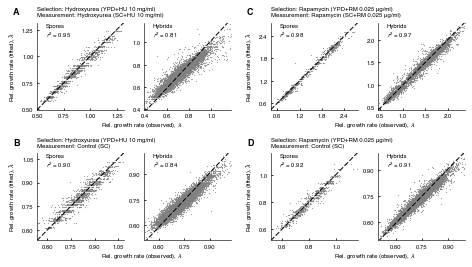

In [7]:
import statsmodels.api as sm

panels = {
    'HU': {
        'HU':(0,0),
        'SC':(1,0)
    },
    'RM': {
        'RM':(0,1),
        'SC':(1,1)
    }
}

fig = plt.figure(figsize=(8, 4))

grid = gridspec.GridSpec(2, 2, hspace=0.5, wspace=0.1)

gs = {}

var_comp = lmm_var_comp.copy()
var_comp['total_variance'] = var_comp.sum(axis=1)
    
for ii, (s, e) in enumerate([('HU','HU'),('HU','SC'),('RM','RM'),('RM','SC')]):
    
    gs[(s, e)] = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[panels[s][e]], wspace=0.02)

for ii, ((s, e), fit_all) in enumerate(lmm_fit.groupby(['selection','environment'], sort=False)):

    for jj, (t, fit_type) in enumerate(fit_all.groupby('type', sort=False)):
        
        ax = plt.subplot(gs[(s,e)][jj])
        utils.simple_axes(ax)
        
        if jj==0:
            ax.text(-0.2, 1.125, chr(ii + ord('A')), transform=ax.transAxes,
                    fontsize=9, fontweight='bold', va='center', ha='right')
            ax.annotate('Selection: %s\nMeasurement: %s' %\
                         (config.selection['long_label'][s], \
                          config.environment['long_label'][e]), 
                        xy=(0, 1.125), xycoords="axes fraction",
                        ha='left', va='center', annotation_clip=False, fontsize=6)

        nobs = len(fit_type.observed_growth_rate)
        y = fit_type.observed_growth_rate
        yhat = fit_type.fitted_growth_rate
        ymin, ymax = y.quantile([.005, .995])
        yrange = ymax - ymin
        
        # Scatter
        ax.scatter(y, yhat, facecolor='gray', s=1.5, lw=0, alpha=0.75, rasterized=True)
        
        # Fit
        line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=False)).fit().params
        fit = lambda x: line_fit[1] + line_fit[0] * x 
        ax.plot(np.linspace(ymin-.1*yrange, ymax+.1*yrange, nobs),
                fit(np.linspace(ymin-.1*yrange, ymax+.1*yrange, nobs)), 
                label=t, color='k', ls='--', dashes=(5, 2), lw=1)
        
        # Variance explained
        var_total = var_comp.groupby(['selection','environment','type']).get_group((s,e,t))['total_variance'].values[0]
        ax.annotate('{}\n' r'$r^2$ = {:.2f}'.format(t.capitalize(), var_total),
                    xy=(.1, .9), xycoords="axes fraction",
                    ha='left', va='center', fontsize=6)
        
        # x-axis
        ax.set_xlim(ymin-.1*yrange, ymax+.1*yrange)
        ax.xaxis.set_major_locator( ticker.MaxNLocator(nbins = 4) )

        # y-axis
        ax.set_ylim(ymin-.1*yrange, ymax+.1*yrange)
        ax.yaxis.set_major_locator( ticker.MaxNLocator(nbins = 4) )
        
        ax.set_aspect('equal', adjustable='box')
    
        if jj==0:
            ax.annotate(r'Rel. growth rate (observed), $\lambda$',
                        xy=(1.2, -0.175), xycoords="axes fraction",
                        ha='center', va='center', annotation_clip=False, fontsize=6)
            ax.set_ylabel(r'Rel. growth rate (fitted), $\hat{\lambda}$', fontsize=6)
    
for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=6, size=2)
    ax.tick_params(axis='both', which='minor', labelsize=6, size=0)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(.6)

plot.save_figure(dir_supp+'figures/supp_figure_pheno_cross/supp_figure_pheno_cross_lmm')
plt.show()

**Fig. S12:** Hierarchical analysis of variance in the genetic cross using linear mixed models. We model the growth rate of spores $\lambda_{\{a,\alpha\}}^{btd}$ and hybrids $\lambda_{a\alpha}^{btd}$ as a function of background genotype $b$, *de novo* genotype $d$, sampling time during selection $t$, and auxotrophy $x$. Relative growth rates are accurately fitted by this model (Model 4). Model fits are summarised in Table S6. Measurements are taken in SC+HU 10 $\text{mg ml}^{-1}$ and SC only for populations selected in hydroxyurea (**A**, **B**); SC+RM 0.025 $\mu \text{g ml}^{-1}$ and SC only for populations selected in rapamycin (**C**, **D**). The scatter shows a set of measurements $\lambda$ ($x$-axis) against the fitted rates $\hat{\lambda}$ ($y$-axis). The total variance explained, $r^2$, is separately computed for spores and hybrids by environment.